2302700 - Muhd Hafiz bin Abdul Halim

2200581 - Muhammad Azreen Bin Muhamamad

Best results are achieved under:
++++++++++++++++++++++

Feature Extractor/Preprocess the dataset=True

Data Augmentation=False

Use-pre-trained-model=True

Finetune=True

Optimizer=adamW

Hyperparameters=True

EarlyStopping=True

Different NN=False

Pooling Layer-=False

++++++++++++++++++++++

# Training Phase


# Check if your using Nvidia GPU
### Amd gpu works too via ROCM on pytorch linux
### Install dataset as both colab and kaggle does not contain it at runtime

In [ ]:
!nvidia-smi #make sure you choose GPU, the default type is CPU, click change runtime type, set hardware accelerator to *GPU

Tue Oct  8 23:50:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!unzip -o small-project.zip -d small-project

unzip:  cannot find or open small-project.zip, small-project.zip.zip or small-project.zip.ZIP.


In [ ]:
!pip install datasets

### Puts input files into seperate folders

In [ ]:
import os
import pandas as pd
import numpy as np
import shutil

df_all = pd.read_csv('small-project/small-project/IEMOCAP_4.tsv',sep='\t')
speakers = np.unique(data_all['speaker']) # only 10 speakers, (['Ses01F', 'Ses01M', 'Ses02F', 'Ses02M', 'Ses03F', 'Ses03M','Ses04F', 'Ses04M', 'Ses05F', 'Ses05M']
spk_len = len(speakers)
spk_len

test_idx = np.array(df_all['speaker']==speakers[0]) # audio from 'Ses01F' as test set
val_idx = np.array(df_all['speaker']==speakers[1]) #  audio from 'Ses01M' as val set
train_idx = True^(test_idx+val_idx)
train_data_info = df_all[train_idx].reset_index(drop=True)
val_data_info = df_all[val_idx].reset_index(drop=True)
test_data_info = df_all[test_idx].reset_index(drop=True)


In [ ]:
og_path = "small-project\small-project\IEMOCAP_full_release_audio"

TRAIN = os.path.join("", 'train')
os.makedirs(TRAIN, exist_ok=True)
TEST = os.path.join("", 'test')
os.makedirs(TEST, exist_ok=True)
VAL = os.path.join("", 'val')
os.makedirs(VAL, exist_ok=True)

for row in train_data_info['filename']:
    original_filepath = os.path.join(og_path, f"{row}.wav")
    new_filepath = os.path.join(TRAIN, f"{row}.wav")
    # Copy the file to the destination folder
    shutil.copy(original_filepath, new_filepath)

for row in test_data_info['filename']:
    original_filepath = os.path.join(og_path, f"{row}.wav")
    new_filepath = os.path.join(TEST, f"{row}.wav")
    # Copy the file to the destination folder
    shutil.copy(original_filepath, new_filepath)


for row in val_data_info['filename']:
    original_filepath = os.path.join(og_path, f"{row}.wav")
    new_filepath = os.path.join(VAL, f"{row}.wav")
    # Copy the file to the destination folder
    shutil.copy(original_filepath, new_filepath)

# Import Package and Ultilty Function


In [ ]:
import random

# Define the seed setup function
def setup_seed(seed=2042):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [ ]:
import os
import pandas as pd
import torchaudio
import torch
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments
import numpy as np

# Path to your dataset and CSV file
TSV = r'/kaggle/input/small-project-dataset/dataset/IEMOCAP_4.tsv' #Change to Collab/Kaggle Directory
DATASET = r'/kaggle/input/small-project-dataset/dataset' #Change to Collab/Kaggle Directory
TRAIN = os.path.join(DATASET, 'train')
TEST = os.path.join(DATASET, 'test')
VAL = os.path.join(DATASET, 'val')

# Verify filepaths
print("Train folder path:", TRAIN)
print("Test folder path:", TEST)
print("Validation folder path:", VAL)

# Define label mapping
label_mapping = {"A": 0, "H": 1, "N": 2, "S": 3}

# Parameters
max_len = 7
epochs = 15
seed = 2042

# Set the seed for reproducibility
setup_seed(seed)

Train folder path: /kaggle/input/small-project-dataset/dataset/train
Test folder path: /kaggle/input/small-project-dataset/dataset/test
Validation folder path: /kaggle/input/small-project-dataset/dataset/val


**Helper functions to pre-process the training data from raw Fbank features of each utterance.**

The sample rate of speech is 16K (the number of samples per second is 16000)

The input length for each utterance is different, cut them to 6s if larger than 6s, copy speech until 6s if less than 6s

In [ ]:
def pad_trunc_wav(x, max_len):
    max_len = max_len * 16000  # Convert to number of samples

    # Ensure consistent input length
    if x.shape[1] < max_len:
        # Pad with zeros if shorter
        padding = max_len - x.shape[1]
        x_new = torch.cat([x, torch.zeros(1, padding)], dim=1)  # Padding on the right
    else:
        # Truncate if longer
        x_new = x[:, :max_len]

    return x_new

In [ ]:
# Load TSV file
label_df = pd.read_csv(TSV, sep='\t')

def load_audio_file(file_path):
    try:
        # Load a wav file using torchaudio
        speech_array, sampling_rate = torchaudio.load(file_path)
        if speech_array.size(1) == 0:  # If no samples are loaded
            print(f"Warning: {file_path} is empty or invalid.")
            return None, None  # Return None for invalid files
        return speech_array.squeeze().numpy(), sampling_rate
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None  # Return None for files that raise exceptions



# Dataset + truncating + Padding

In [ ]:
def load_dataset(audio_folder, label_df):
    data = []

    for index, row in label_df.iterrows():
        file_name = row["filename"] + ".wav"  # Ensure filename has .wav extension
        label_str = row["label"]  # Original string label from CSV
        file_path = os.path.join(audio_folder, file_name)

        # Check if the file exists and has a .wav extension
        if os.path.exists(file_path) and file_path.endswith(".wav"):
            speech, sampling_rate = load_audio_file(file_path)

            # Apply the pad_trunc_wav function to ensure consistent audio length
            speech = torch.tensor(speech).unsqueeze(0)  # Add batch dimension for padding
            speech = pad_trunc_wav(speech, max_len=max_len).squeeze(0)  # Remove batch dimension after padding/truncating

            # Map the string label to its numerical equivalent using the label mapping
            if label_str in label_mapping:
                label = label_mapping[label_str]
            else:
                raise ValueError(f"Unknown label '{label_str}' encountered.")

            # Append the data dictionary
            data.append({"speech": speech, "sampling_rate": sampling_rate, "label": label})

    # Create the dataset from the loaded data
    return Dataset.from_dict({
        "speech": [d["speech"] for d in data],
        "sampling_rate": [d["sampling_rate"] for d in data],
        "label": [d["label"] for d in data]
    })

# Load your dataset
training = load_dataset(TRAIN, label_df)
testing = load_dataset(TEST, label_df)
validation = load_dataset(VAL, label_df)
print("Total Files Loaded:")
print(f"Training Total Amount: {len(training)}")
print(f"Testing Total Amount: {len(testing)}")
print(f"Validation Total Amount: {len(validation)}")

# Define a DatasetDict object
emotion_dataset = DatasetDict({
    "train": training,
    "test": testing,
    "val": validation
})

Total Files Loaded:
Training Total Amount: 4446
Testing Total Amount: 528
Validation Total Amount: 557


# Load Pretrained Model for Feature Extractor + Define the prerocess function
Model we are using is Wav2Vec2 facebook baselin variant https://huggingface.co/docs/transformers/en/model_doc/wav2vec2 this is to ensure a fair training process and to fufill the no IEMOCAP pretuned criteria

In [ ]:
# Load the Wav2Vec2 feature extractor and model
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base")
model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=4  # Adjust this to match the number of emotion classes in your dataset
)

# Preprocess the dataset
def preprocess_function(examples):
    # Ensure that the inputs are numpy arrays and float32 type
    audio_inputs = [speech.astype(np.float32) for speech in examples["speech"]]
    # Use the feature extractor to process the audio inputs
    inputs = feature_extractor(audio_inputs, sampling_rate=16000, return_tensors="pt", padding=True)
    inputs["label"] = examples["label"]  # Add labels to the inputs
    return inputs


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load a Saved Processed Dataset or Start Training One

Only start processing the dataset if you think there is going to be improvement to the training process later on. One is provided for you to save time.

### Preprocessing a Dataset with a Feature Extractor before Training

Preprocessing a dataset with a feature extractor before training is essential for several reasons, especially when working with audio, image, or text data. Here's why:

#### 1. Normalization
Feature extraction ensures that the input data is normalized to a standard format, which helps the model learn efficiently. For example, in audio processing, feature extractors like Wav2Vec2 convert raw waveforms into a consistent feature representation (e.g., mel spectrograms or embeddings).

#### 2. Dimensionality Reduction
Extracting key features reduces the dimensionality of the data, removing redundant or irrelevant information. This helps in making the training process more efficient by focusing on the most important patterns in the data.

#### 3. Consistency
Raw data like audio or text can vary significantly in length or format (e.g., different sampling rates, noise levels, or accents). Feature extraction standardizes the input, ensuring that the model receives consistent input across the dataset.

#### 4. Improved Learning
Models typically perform better when trained on features that highlight relevant patterns. For instance, in speech emotion recognition, feature extraction might focus on intonation, pitch, and pauses, which are more useful for emotion detection than raw audio.

#### 5. Faster Convergence
By transforming the raw data into a more compact and informative representation, feature extraction can help the model converge faster during training, reducing the computational cost.


In [ ]:
'''
# Install gdown if not already installed
!pip install gdown

# Download the file from Google Drive
import gdown

# Google Drive file URL
file_url = "https://drive.google.com/uc?id=1QvTdLI6TAWIlot9gVw4eGgAQgdaqSQA3"

# Specify the output file name
output = "downloaded_file.zip"

# Download the file
gdown.download(file_url, output, quiet=False)

# Unzip the downloaded file
import zipfile
import os

# Unzipping the file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("unzipped_files")

# List the extracted files
os.listdir("unzipped_files")

# Remove the zip file
import os
os.remove(output)
'''

In [ ]:
# Load or process the dataset
LOAD = False # Set to true if you already have a processed_dataset one can be found in this link if you want to save time its from Azreen Gdrive https://drive.google.com/file/d/1QvTdLI6TAWIlot9gVw4eGgAQgdaqSQA3/view?usp=drive_link

if LOAD:
    from datasets import load_from_disk
    emotion_dataset = load_from_disk('/kaggle/input/small-project-dataset/dataset/processed_dataset') #Change to Collab/Kaggle Directory
    print("Processed dataset loaded")
else:
    emotion_dataset = emotion_dataset.map(preprocess_function, batched=True)
    emotion_dataset.save_to_disk('./processed_dataset') #Change to Collab/Kaggle Directory

feature_extractor.save_pretrained("./wav2vec2-test") #Change to Collab/Kaggle Directory

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

Processed dataset loaded


# Declare Optimizer (Adam)


In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Model Training

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStoppingCallback(early_stopping_patience=5)

print(f"Is CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    model = model.to('cuda')
    print("Model moved to GPU.")

training_args = TrainingArguments(
    output_dir="./wav2vec2-test",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    weight_decay = 0.1,  # Regularization to prevent overfitting
    gradient_accumulation_steps = 2,  # Simulates a larger batch size without increasing memory usage
    warmup_steps = 100,  # Number of steps for learning rate warmup
    learning_rate = 1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps= 1,
    num_train_epochs=epochs,
    save_steps=10,
    save_total_limit=2,
    logging_dir="./logs",
    fp16=True,
    dataloader_pin_memory=True,
    load_best_model_at_end=True,
    dataloader_num_workers=0,
    report_to="none"  # Add a unique name for this training run
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_dataset["train"],
    eval_dataset=emotion_dataset["val"],
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),  # Pass the optimizer, scheduler can be None
    callbacks=[early_stopping]
)

# Start training
trainer.train()

Is CUDA available: True
Model moved to GPU.


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
0,1.028200,1.113257,0.495512
2,0.882500,0.975748,0.596050
4,0.730500,0.983623,0.621185
6,0.575800,0.994184,0.644524
8,0.466800,0.980187,0.658887
10,0.376300,1.074139,0.653501


TrainOutput(global_step=764, training_loss=0.6690670133261156, metrics={'train_runtime': 7722.171, 'train_samples_per_second': 8.636, 'train_steps_per_second': 0.134, 'total_flos': 2.664012126657024e+18, 'train_loss': 0.6690670133261156, 'epoch': 10.992805755395683})

# Evaluate Metrics

In [ ]:
# Evaluate the model
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.9421173930168152, 'eval_accuracy': 0.6481149012567325, 'eval_runtime': 56.6437, 'eval_samples_per_second': 9.833, 'eval_steps_per_second': 0.318, 'epoch': 10.992805755395683}


In [ ]:
# Save the model
model_save_path = "/kaggle/working/wav2vec2-emotion-model" # Change filepath
model.save_pretrained(model_save_path)

# Save the feature extractor
feature_extractor.save_pretrained(model_save_path)

print(f"Model and feature extractor saved to {model_save_path}")

Model and feature extractor saved to /kaggle/working/wav2vec2-emotion-model


# Visulazation for better analysis

## Plot Training and Validation Loss per Epoch

In [ ]:
# Extract log history
log_history = trainer.state.log_history

# Extract training and validation loss per epoch
training_loss = []
validation_loss = []
epochs_logged = []

for log in log_history:
    if "loss" in log:  # Training loss
        training_loss.append(log["loss"])
        epochs_logged.append(log["epoch"])
    if "eval_loss" in log:  # Validation loss
        validation_loss.append(log["eval_loss"])


In [ ]:
print(f"Validation Loss: {len(validation_loss)}")
print(f"Loss log: {len(training_loss)}")
print(f"Epochs Logged: {len(epochs_logged)}")

Validation Loss: 12
Loss log: 11
Epochs Logged: 11


In [ ]:
print(f"Validation Loss: {validation_loss}")
print(f"Loss log: {training_loss}")
print(f"Epochs Logged: {epochs_logged}")

Validation Loss: [1.1132571697235107, 1.0548527240753174, 0.9757477045059204, 0.9611093401908875, 0.9836232662200928, 0.9421173930168152, 0.9941842555999756, 1.0552035570144653, 0.9801869988441467, 1.0427708625793457, 1.0741393566131592, 0.9421173930168152]
Loss log: [1.0282, 0.9626, 0.8825, 0.7939, 0.7305, 0.6373, 0.5758, 0.4996, 0.4668, 0.4068, 0.3763]
Epochs Logged: [0.9928057553956835, 2.0, 2.9928057553956835, 4.0, 4.9928057553956835, 6.0, 6.9928057553956835, 8.0, 8.992805755395683, 10.0, 10.992805755395683]


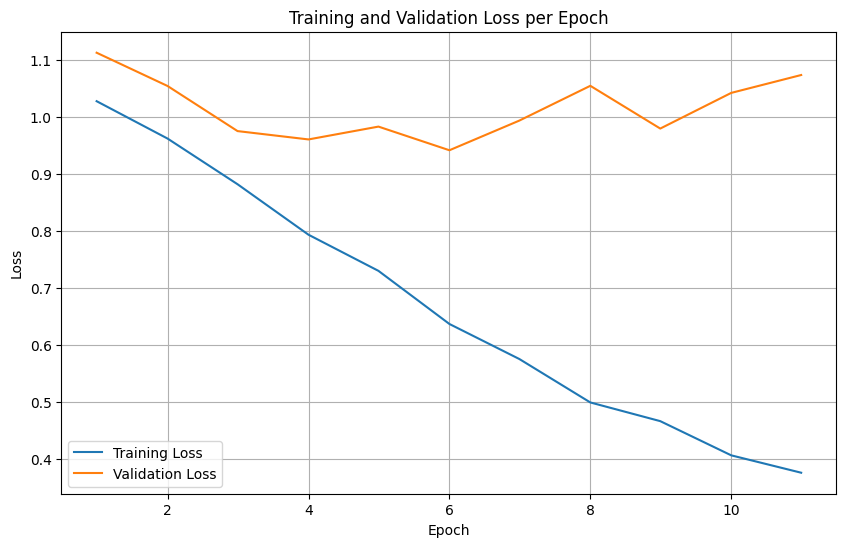

In [ ]:
import matplotlib.pyplot as plt

# Ensure validation loss is padded to match length of training loss (if necessary)
if len(validation_loss) < len(training_loss):
    validation_loss += [validation_loss[-1]] * (len(training_loss) - len(validation_loss))
if len(validation_loss) > len(training_loss):
    validation_loss.pop()
# Plot training and validation loss

plt.figure(figsize=(10, 6))
plt.plot(epochs_logged, training_loss, label="Training Loss")
plt.plot(epochs_logged, validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()


# Save the Model and zipped it for download for future use

In [ ]:
import shutil
from IPython.display import FileLink

# 圧縮するフォルダと出力するZIPファイル名
model_save_path = '/kaggle/working/wav2vec2-emotion-model'
zip_file_path = '/kaggle/working/wav2vec2-emotion-model.zip'

# フォルダをZIPファイルに圧縮
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', model_save_path)

# ZIPファイルへのリンクを表示
FileLink(zip_file_path)

/kaggle/working/wav2vec2-emotion-model.zip

# Inference Phase

You only need to run this part if you altrady have finished training the model or have one downloaded. The code is setup in a way that  that you can drag and drop your model of choice to predict. So while we settled on wav2vec2 you can change it and we will show where and how you need to tweak it for that to happen.

In [ ]:
from transformers import AutoFeatureExtractor, AutoModelForAudioClassification
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import glob
import csv

In [ ]:
# Specify the path to your test folder
target_sampling_rate = 16000
test_folder_path = r'/kaggle/input/small-project-dataset/dataset/test' #Change to Collab/Kaggle Directory

# Load Feature Extractor
## Aditionally take note of the Labels for remapping


In [ ]:
# Load saved model
# Path where the model and feature extractor are saved
model_save_path = "/kaggle/working/wav2vec2-emotion-model" #Change to Collab/Kaggle Directory

# Load the model
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_save_path)

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained('facebook/wav2vec2-base-960h')

print("Model and feature extractor loaded successfully!")
print(f"Model Labels:  {model.config.id2label}")
print("Wanted Labels: {0: 'ang', 1: 'hap', 2: 'neu', 3: 'sad'}")

Model and feature extractor loaded successfully!
Model Labels:  {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2', 3: 'LABEL_3'}
Wanted Labels: {0: 'ang', 1: 'hap', 2: 'neu', 3: 'sad'}


# Define the Prediction Function

In [ ]:
def predict(test_folder_path, output_csv='prediction.csv'):

    # Get a list of all .wav files in the test folder
    audio_files = glob.glob(os.path.join(test_folder_path, '*.wav'))

    # Prepare a list to hold the results
    results = []
    count = 1


    # Iterate over each audio file in the test folder
    for audio_file in audio_files:

        print(f'File: {count}', end='\r')
        count += 1

        # Load the audio file
        y_ini, sr_ini = librosa.load(audio_file, sr=target_sampling_rate)

        # Extract features from the audio
        inputs = feature_extractor(y_ini, sampling_rate=target_sampling_rate, return_tensors="pt")

        # Get the logits from the model
        with torch.no_grad():
            logits = model(**inputs).logits

        # Predict the class with the highest logit value
        predicted_class_id = torch.argmax(logits).item()

        # Extract the filename without the extension
        filename = os.path.splitext(os.path.basename(audio_file))[0]

        # Append the result to the list
        results.append([filename, predicted_class_id])

    # Write the results to a CSV file
    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['ID', 'Predict'])
        # Write data
        writer.writerows(results)

    print(f"Predictions saved to {output_csv}")

In [ ]:
import librosa

# Run the prediction

In [ ]:
predict(test_folder_path)

Predictions saved to prediction.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Declare the confusion matrix

In [ ]:
def show_confusion_matrix(file1, file2, save):

    # Read the TSV files
    df1 = pd.read_csv(file1, sep='\t')
    df2 = pd.read_csv(file2)

    # Remap predictions before reading as every model have their own label name but since we trained it before hand to handle the label this is for analysis purpose
    '''
    (N)eutral Mapped to: 2
    (H)appy Mapped to: 1
    (S)ad Mapped to: 3
    (A)ngry Mapped to: 0
    '''

    # Define a remapping dictionary
    remap_dict = {
        0: 'A',
        1: 'H',
        2: 'N',
        3: 'S'
    }

    # Apply the remap function to the 'Predict' column
    df2['Predict'] = df2['Predict'].map(remap_dict)

    # Merge DataFrames on 'filename'
    df_merged = pd.merge(df1[['filename', 'label']],df2[['ID', 'Predict']],left_on='filename',right_on='ID')

    # Extract true labels and predictions
    y_true = df_merged['label']
    y_pred = df_merged['Predict']

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for the confusion matrix
    labels = sorted(y_true.unique())
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute and print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")

    # Compute and print UA score
    macro_recall = recall_score(y_true, y_pred, average='macro')
    print(f"test UA: {macro_recall}")

    # Print the confusion matrix
    #print("Confusion Matrix:")
    #print(cm_df)

    # Compute and print classification report
    report = classification_report(y_true, y_pred, labels=labels)
    print("\nClassification Report:")
    print(report)


    if save:
        # Save the updated dataframe back to a CSV file
        df_merged.to_csv('prediction_results.csv', index=False)
        print("Saved")


# Load the tsv and the prediction.csv

In [ ]:
tsv_file = r'/kaggle/input/small-project-dataset/dataset/IEMOCAP_4.tsv'  #Change to Collab/Kaggle Directory

# For Validation of code
predictions = [
   '/kaggle/working/prediction.csv', #Change to Collab/Kaggle Directory
]


# Display the confusion matrix for additional insight

FILEPATH: /kaggle/working/prediction.csv


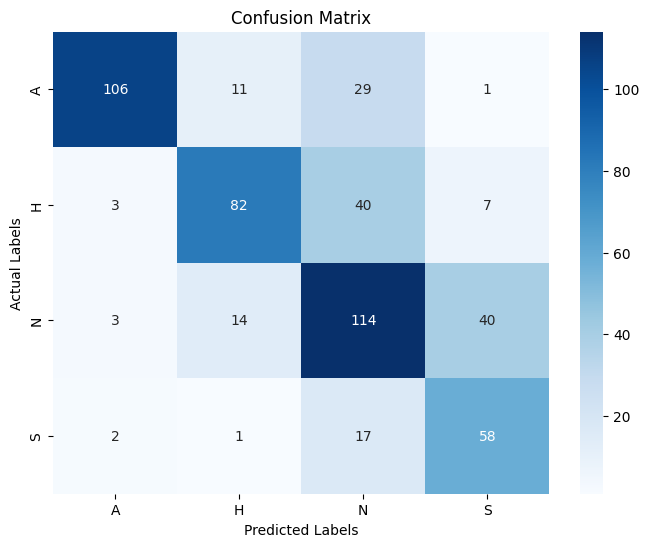

Accuracy: 0.6818181818181818
test UA: 0.6881392417106703

Classification Report:
              precision    recall  f1-score   support

           A       0.93      0.72      0.81       147
           H       0.76      0.62      0.68       132
           N       0.57      0.67      0.61       171
           S       0.55      0.74      0.63        78

    accuracy                           0.68       528
   macro avg       0.70      0.69      0.69       528
weighted avg       0.71      0.68      0.69       528



In [ ]:
for prediction in reversed(predictions):
    print(f"FILEPATH: {prediction}")
    show_confusion_matrix(tsv_file, prediction, False)

# Previous Attempts and Methods

# Orginial Model before pretrained
###Simplified version from "3-D Convolutional Recurrent Neural Networks With Attention Model for Speech Emotion Recognition"

![altertext](https://drive.google.com/uc?id=1bHrsMSjWKf1XgmCshPrSU81fVSsNhfP4)

[Paper link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8421023&casa_token=AGqWGVSS5lAAAAAA:cM6X58aNcHVZmsVC1r_ZxawguzlzMHMhxZzsLdxdYf7ogidcBmUmMHhgwKH6H33TGBGRXV1XUQYo0A&tag=1)

[Github link](https://github.com/xuanjihe/speech-emotion-recognition/tree/master)

In [ ]:
'''
Orignial Model (before pretrained)
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import soundfile as sound
import datetime
import sys, subprocess
import math
import random
import librosa
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm import tqdm
import logging
import time

from sklearn.metrics import confusion_matrix, classification_report, recall_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchaudio import functional as audioF
from torchaudio.compliance import kaldi

def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

class Pad_trunc_wav(nn.Module):
    def __init__(self, max_len: int = 6*16000):
        super(Pad_trunc_wav, self).__init__()
        self.max_len = max_len
    def forward(self,x):
        shape = x.shape
        length = shape[1]
        if length < self.max_len:
            multiple = self.max_len//length+1
            x_tmp = torch.cat((x,)*multiple, axis=1)
            x_new = x_tmp[:,0:self.max_len]
        else:
            x_new = x[:,0:self.max_len]
        return x_new

class Deltas_Deltas_FBank(nn.Module):
    #(…, freq, time)
    def __init__(self):
        super(Deltas_Deltas_FBank, self).__init__()
    def forward(self,x):
        # x: time*freq
        x = x.permute(1,0).unsqueeze(0)
        delta = audioF.compute_deltas(x)
        delta2 = audioF.compute_deltas(delta)
        x_out = torch.cat((x,delta,delta2), 0).permute(0,2,1)
        # x_out: 3*freq*time -> 3*time*freq
        return x_out

!pip install audiomentations

from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion, Gain
# Define a composite augmentation object with multiple augmentations applied sequentially
augment = Compose([
    # This augmentation adds Gaussian noise to the audio signal.
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),

    # This augmentation changes the pitch of the audio signal by shifting it up or down by a random number of semitones within the specified range.
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),

    # This augmentation changes the tempo of the audio signal by stretching or compressing it.
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),

    # This augmentation simulates clipping distortion by applying a random threshold (in percentile) to the audio signal
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=10, p=0.4),

    # This augmentation adjusts the volume (gain) of the audio signal by applying a random gain factor within the specified range.
    Gain(min_gain_in_db=-6, max_gain_in_db=6, p=0.5),

])

class Mydataset(Dataset):
    def __init__(self, mode='train', max_len=6, seed=42):
        self.mode = mode
        data_all = pd.read_csv('small-project/small-project/IEMOCAP_4.tsv',sep='\t')
        SpkNames = np.unique(data_all['speaker']) # only 10 speakers, (['Ses01F', 'Ses01M', 'Ses02F', 'Ses02M', 'Ses03F', 'Ses03M','Ses04F', 'Ses04M', 'Ses05F', 'Ses05M']
        self.data_info = self.split_dataset(data_all, SpkNames)
        self.get_audio_dir_path = os.path.join('small-project/small-project/IEMOCAP_full_release_audio/')
        self.pad_trunc = Pad_trunc_wav(max_len*16000)
        self.transform = Deltas_Deltas_FBank()
        # label is emotion type:  A: Angry  H: Happy, N: Natural, S: Sad
        self.label = self.data_info['label'].astype('category').cat.codes.values

        self.ClassNames = np.unique(self.data_info['label'])
        self.NumClasses = len(self.ClassNames)
        if mode == 'train':
          print("Each emotion has the following number of training samples:")
          print([[self.ClassNames[i], (self.label == i).sum()] for i in range(self.NumClasses)])
        self.weight = 1/torch.tensor([(self.label==i).sum() for i in range(self.NumClasses)]).float()

    def get_classname(self):
        return  self.ClassNames

    def split_dataset(self, df_all, speakers):
        spk_len = len(speakers)
        test_idx = np.array(df_all['speaker']==speakers[0]) # audio from 'Ses01F' as test set
        val_idx = np.array(df_all['speaker']==speakers[1]) #  audio from 'Ses01M' as val set
        train_idx = True^(test_idx+val_idx)
        train_data_info = df_all[train_idx].reset_index(drop=True)
        val_data_info = df_all[val_idx].reset_index(drop=True)
        test_data_info = df_all[test_idx].reset_index(drop=True)

        if self.mode == 'train':
            data_info = train_data_info
        elif self.mode == 'val':
            data_info = val_data_info
        elif self.mode == 'test':
            data_info = test_data_info
        else:
            data_info = df_all
        return data_info

    def pre_process(self, wav): #updated!!
        # Normalize the waveform
        if torch.max(torch.abs(wav)) != 0:
            wav = wav / torch.max(torch.abs(wav)) # Normalize to [-1, 1] range
        wav = self.pad_trunc(wav)  # Pad or truncate the waveform to the desired length
        return wav

    def extract_fbank(self, wav, sample_rate):
        wav = wav * (1 << 15)
        if sample_rate!=16000:
            # if sample rate is not 16k, change (transform) to 16k
            wav = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(wav)
        # Extract Raw Fbank feature, the Fbank feature dimension is 80
        spec = kaldi.fbank(wav,num_mel_bins=80,frame_length=25,frame_shift=10,sample_frequency=16000,high_freq=8000,low_freq=0,window_type='hamming')
        return spec

    def copy_paste(self, emo_wav, neutral_wav):
        # Concatenate an emotional utterance and a neutral utterance
        augmented_wav = torch.cat((emo_wav, neutral_wav), dim=-1)  # Concatenate along the time dimension
        return augmented_wav

    def apply_augmentations(self, wav, sample_rate): #added
        # Convert PyTorch tensor to numpy for augmentation
        wav_numpy = wav.numpy().flatten()

        # Apply augmentations
        augmented_wav = augment(samples=wav_numpy, sample_rate=sample_rate)

        # Convert back to PyTorch tensor
        wav = torch.tensor(augmented_wav).unsqueeze(0)

        return wav
    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        wav, sample_rate = torchaudio.load(os.path.join(self.get_audio_dir_path, self.data_info.filename[idx]) + '.wav')
         # Apply augmentations if in training mode
        if self.mode == 'train':
            # Applies GaussianNoise, PitchShift, TimeStretch, ClippingDistorition, and Gain augments
            wav = self.apply_augmentations(wav, sample_rate)
            # Combines emotional and neutral file to create a new sample
            if np.random.rand() < 0.5:
                # Index(['A', 'H', 'N', 'S'], dtype='object')
                neutral_idx = np.random.choice(np.where(self.label == 2)[0])
                neutral_wav, _ = torchaudio.load(os.path.join(self.get_audio_dir_path, self.data_info.filename[neutral_idx]) + '.wav')
                wav = self.copy_paste(wav, neutral_wav)


        wav = self.pre_process(wav)
        spec = self.transform(self.extract_fbank(wav, sample_rate)).float()
        label = torch.tensor(self.label[idx], dtype=torch.long)

        return spec, label, self.data_info.filename[idx]

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class Mymodel(nn.Module):
    def __init__(self, feature_size=80, h_dims=256, emotion_cls=4):
        super(Mymodel, self).__init__()
        self.bn0 = nn.BatchNorm2d(feature_size)

        self.conv_block1 = self.ConvBlock5x5(in_channels=3, out_channels=64)
        self.conv_block2 = self.ConvBlock5x5(in_channels=64, out_channels=128)
        self.conv_block3 = self.ConvBlock5x5(in_channels=128, out_channels=256)
        self.conv_block4 = self.ConvBlock5x5(in_channels=256, out_channels=512)

        self.att_block = self.AttBlock(512, h_dims, activation='linear')

        self.fc1 = nn.Linear(h_dims, h_dims // 2)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5) #previously it was 0.3
        self.bn = nn.BatchNorm1d(h_dims // 2)
        self.fc2 = nn.Linear(h_dims // 2, emotion_cls)
        self.outlayer = nn.LogSoftmax(dim=-1)

    class AttBlock(nn.Module):
        def __init__(self, n_in, n_out, activation='linear', temperature=1.):
            super(Mymodel.AttBlock, self).__init__()

            self.activation = activation
            self.temperature = temperature
            self.att = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)
            self.cla = nn.Conv1d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=1, padding=0, bias=True)

            self.bn_att = nn.BatchNorm1d(n_out)

        def forward(self, x):
            norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
            cla = self.nonlinear_transform(self.cla(x))
            x = torch.sum(norm_att * cla, dim=2)
            return x, norm_att, cla

        def nonlinear_transform(self, x):
            if self.activation == 'linear':
                return x
            elif self.activation == 'sigmoid':
                return torch.sigmoid(x)

    class ConvBlock5x5(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(Mymodel.ConvBlock5x5, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=in_channels,
                                   out_channels=out_channels,
                                   kernel_size=(3, 3), stride=(1, 1), #Kernel_size previously is 5 , 5
                                   padding=(1, 1), bias=False) #padding was pewviously 2, 2. Network in a Network Approach
            self.bn1 = nn.BatchNorm2d(out_channels)

        def forward(self, input, pool_size=(2, 2), pool_type='avg'):
            x = input
            x = F.relu_(self.bn1(self.conv1(x)))
            if pool_type == 'max':
                x = F.max_pool2d(x, kernel_size=pool_size)
            elif pool_type == 'avg':
                x = F.avg_pool2d(x, kernel_size=pool_size)
            elif pool_type == 'avg+max':
                x1 = F.avg_pool2d(x, kernel_size=pool_size)
                x2 = F.max_pool2d(x, kernel_size=pool_size)
                x = x1 + x2
            else:
                raise Exception('Incorrect argument!')
            return x

    def forward(self, inputs):
        x = inputs.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='max')
        x = F.dropout(x, p=0.5, training=self.training)

        x = torch.mean(x, dim=3)  # (batch_size, channels, time)
        #att_output, norm_att, cla = self.att_block(x) #
        x = torch.sum(x, dim=2)
        emo_ebd = x
        x = self.dropout(self.activation(self.bn(self.fc1(x))))
        pred = self.outlayer(self.fc2(x))

        return pred, emo_ebd

# Setup environment and arguments
seed = 2024 # random seed
batch_size = 128  # batch size, reduce batch size, if you get out of memory problem
epochs = 65  # the number of training epoch I reduced to 65 but original is 100. This is done as the curent method is unlikely to reach 100
max_len = 6 # the input length for training
lr = 1e-3  # learning rate originally 1e-3 will adjust once more variables are fine tuned
loss_type = 'CE' #loss function
optimizer_type = 'Adam' # optimizer, can try Adam or others

def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter("[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s")
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    logger.addHandler(sh)

    return logger

def train(model, device, train_loader, criterion, optimizer, epoch, logger):
    model.train()
    logger.info('start training')

    lr = optimizer.param_groups[0]["lr"]
    logger.info('lr: {:.5f}'.format(lr))

    correct = 0

    for batch, data in tqdm(enumerate(train_loader)):
        spec, emo_label,_ = data
        spec, emo_label = spec.to(device), emo_label.to(device)
        optimizer.zero_grad()

        emo_output,_ = model(spec)
        loss = criterion(emo_output, emo_label)

        loss.backward()
        nn.utils.clip_grad_norm_([param for param in model.parameters() if param.requires_grad], max_norm=10, norm_type=2)
        optimizer.step()

        pred = emo_output.argmax(dim=1, keepdim=True)
        correct += pred.eq(emo_label.view_as(pred)).sum().item()

        if batch % 20 == 0:
            logger.info('Epoch: {} [{}/{} ({:.0f}%)]\t loss={:.5f}\t '.format(epoch , batch * len(emo_label), len(train_loader.dataset), 100. * batch / len(train_loader), loss.item()))

    logger.info('Train set Accuracy: {}/{} ({:.3f}%)'.format(correct, len(train_loader.dataset), 100. * correct / (len(train_loader.dataset))))
    logger.info('finish training!')
    return loss

import pandas as pd
def test(model, device, dataset_type, val_loader, criterion, logger, target_names):
    model.eval()
    test_loss = 0
    correct = 0
    logger.info('testing on {}'.format(dataset_type))

    pred_all = np.array([],dtype=np.int64)
    true_all = np.array([],dtype=np.int64)
    nameIDs = np.array([],dtype=str)

    embs_all = []  # Collect all embeddings

    with torch.no_grad():
        for spec, label, nameID in tqdm(val_loader):
            #spec, label = [x.to(device) for x in spec], label.to(device)
            spec, label = spec.to(device), label.to(device)
            output,embs = model(spec)
            test_loss += criterion(output, label).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            pred = output.data.max(1)[1].cpu().numpy()
            true = label.data.cpu().numpy()
            pred_all = np.append(pred_all,pred)
            true_all = np.append(true_all,true)
            nameIDs = np.append(nameIDs,nameID)

            embs_all.append(embs.cpu().numpy())  # Collect embeddings

    test_loss /= len(val_loader.dataset)
    acc = 100. * correct / len(val_loader.dataset)

    logger.info('{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(dataset_type,
        test_loss, correct, len(val_loader.dataset), acc))

    if dataset_type == 'test':
      con_mat = confusion_matrix(true_all,pred_all)
      cls_rpt = classification_report(true_all,pred_all,target_names=target_names,digits=3)
      logger.info('Confusion Matrix:\n{}\n'.format(con_mat))
      logger.info('Classification Report:\n{}\n'.format(cls_rpt))
      # Check if lengths match
      if len(nameIDs) == len(pred_all):
          # Create DataFrame with the combined data
          df = pd.DataFrame({
              'ID': nameIDs,
              'Predict': pred_all,
          })

          # Save DataFrame to a CSV file
          df.to_csv('label.csv', index=False)
          print("Data successfully saved to label.csv, please submit label.csv to Kaggle to see the ranking if the testUA > 0.5453.")
      else:
          print(f"Length mismatch: nameIDs length is {len(nameIDs)}, pred_all length is {len(pred_all)}")
      #np.savez('results.npz', true_all=true_all, pred_all=pred_all)


    UA = recall_score(true_all,pred_all,average='macro')
    WA = recall_score(true_all,pred_all,average='weighted')


    # Concatenate all embeddings
    embs_all = np.concatenate(embs_all, axis=0)

    return test_loss,UA,WA, embs_all, true_all

def early_stopping(network,savepath,metricsInEpochs,gap):
    best_metric_inx=np.argmax(metricsInEpochs)
    if best_metric_inx+1==len(metricsInEpochs):
        best = os.path.join(savepath, 'best_epoch_{}.pt'.format(best_metric_inx+1))
        torch.save(network,best)
        return False
    elif (len(metricsInEpochs)-best_metric_inx >= gap):
        return True
    else:
        return False

savedir = 'exp'
setup_seed(seed)
stamp = datetime.datetime.now().strftime('%y%m%d%H%M')
tag = stamp + '_' + str(epochs)
try:
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise

logpath = savedir + "/exp.log"
modelpath = savedir + "/model.pt"

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

train_set = Mydataset(mode='train', max_len=max_len,  seed=seed)
val_set = Mydataset( mode='val', max_len=max_len, seed=seed)
test_set = Mydataset( mode='test', max_len=max_len, seed=seed)

drop_last = True if len(train_set)%batch_size<2 else False
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=drop_last)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

#print(f"Number of batches in the train_loader: {len(train_loader)}")
#print(f"Number of samples in the train_dataset: {len(train_dataset)}")

# Set the device to CPU (Maybe dont use it for final output as it takes 1hour per epoch. Best used to debug the code before it starts the epoch cycle)
#device = torch.device('cpu')

# Initialize the model on CPU
model = Mymodel(feature_size=80, h_dims=512, emotion_cls=train_set.NumClasses).to(device)

# If you need to load a saved model, ensure it loads to the CPU
# model = torch.load('exp/model.pt', map_location=torch.device('cpu')) (dont uncomment prob not needed rn)

# Criterion
if loss_type == 'CE':
    criterion = nn.NLLLoss()
    criterion_test = nn.NLLLoss(reduction='sum')
else:
    raise NameError

# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-5)
elif optimizer_type == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=lr)
else:
    raise NameError

# Logger
logger = get_logger(logpath)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=15, factor=0.1, verbose=True)

val_UA_list = []
test_UA_dic = {}
test_WA_dic = {}

train_losses = []
val_losses = []

for epoch in range(1, epochs+1):
    print("\n\n")
    start = time.time()
    train_loss = train(model, device, train_loader, criterion, optimizer, epoch, logger)
    train_losses.append(train_loss)

    time.sleep(0.003)
    val_loss,val_UA,_,_,_= test(model, device, 'val', val_loader, criterion_test, logger, train_set.ClassNames)
    val_losses.append(val_loss)
    end = time.time()
    duration = end-start
    val_UA_list.append(val_UA)
    if early_stopping(model,savedir,val_UA_list,gap=20):
        print('val loss has not been decreased for . epochs, stop training \n')
        break

    scheduler.step(val_UA)
    logger.info("-"*50)
    logger.info('EPOCH {:2d} | TIME {:5.4f} sec | Valid Loss {:5.4f} '.format(epoch, duration, val_loss))
    logger.info("-"*50)
    time.sleep(0.003)

'''

# Attempted dual model approach
This tried to incoperate an ASR to help train the SER model with the Multi Task learning layer to combine but due to the complexity and time constraint we never finished this build. Its here to show we attempted it. The paper that I was inspired to do this is in the following [Paper link](https://www.isca-archive.org/interspeech_2021/cai21b_interspeech.pdf)

In [ ]:
'''
Insert the SER+ASR Model code here
import os
import pandas as pd
import torchaudio
import torch
from datasets import Dataset, DatasetDict
from transformers import EarlyStoppingCallback
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification, Wav2Vec2ForCTC, Wav2Vec2Processor, Trainer, TrainingArguments
import numpy as np

# Path to your dataset and CSV file
TSV = r'C:\Users\azree\Downloads\AAI3001_Project\labels\IEMOCAP_4.tsv'
DATASET = r'C:\Users\azree\Downloads\AAI3001_Project\dataset'
TRAIN = os.path.join(DATASET, 'train')
TEST = os.path.join(DATASET, 'test')
VAL = os.path.join(DATASET, 'val')

# Verify filepaths
print("Train folder path:", TRAIN)
print("Test folder path:", TEST)
print("Validation folder path:", VAL)

# Define label mapping
label_mapping = {"A": 0, "H": 1, "N": 2, "S": 3}

# Parameters
max_len = 6
epochs = 5
learning_rate = 5e-5
weight_decay = 0.1
batch_size = 16
gradient_accumulation_steps = 2
warmup_steps = 500

# Load Wav2Vec2 Processor and ASR Model for Transcription
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
asr_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

# Load Wav2Vec2 Feature Extractor and Model for Emotion Recognition
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-large-960h", num_labels=4)

# Data Augmentation
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion

augment = Compose([
    # This augmentation adds Gaussian noise to the audio signal.
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    # This augmentation changes the pitch of the audio signal by shifting it up or down by a random number of semitones within the specified range.
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    # This augmentation changes the tempo of the audio signal by stretching or compressing it.
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    # This augmentation simulates clipping distortion by applying a random threshold (in percentile) to the audio signal
    ClippingDistortion(min_percentile_threshold=0, max_percentile_threshold=10, p=0.4)
])

def load_dataset_with_transcriptions(audio_folder, label_df):
    data = []
    for index, row in label_df.iterrows():
        file_name = row["filename"] + ".wav"
        label_str = row["label"]
        file_path = os.path.join(audio_folder, file_name)

        if os.path.exists(file_path) and file_path.endswith(".wav"):
            speech, sampling_rate = load_audio_file(file_path)
            if speech is not None:
                # Pad/Truncate audio to fixed length
                speech = torch.tensor(speech).unsqueeze(0)
                speech = pad_trunc_wav(speech, max_len=max_len).squeeze(0)

                # Apply data augmentation
                augmented_speech = augment(speech.numpy(), sampling_rate=sampling_rate)
                augmented_speech = torch.tensor(augmented_speech).unsqueeze(0)
                augmented_speech = pad_trunc_wav(augmented_speech, max_len=max_len).squeeze(0)

                # Transcribe audio (ASR)
                transcription = transcribe_audio(speech.numpy())
                print(f"Transcription: {transcription}")

                # Map label to integer
                if label_str in label_mapping:
                    label = label_mapping[label_str]
                else:
                    raise ValueError(f"Unknown label '{label_str}' encountered.")

                # Append to dataset
                data.append({"speech": speech, "augmented_speech": augmented_speech, "transcription": transcription, "label": label})
    return Dataset.from_dict({
        "speech": [d["speech"] for d in data],
        "augmented_speech": [d["augmented_speech"] for d in data],
        "transcription": [d["transcription"] for d in data],
        "label": [d["label"] for d in data]
    })

# Define Dataset
emotion_dataset = load_dataset_with_transcriptions(TRAIN, pd.read_csv(TSV))

# Preprocessing Function
def preprocess_function(examples):
    inputs = feature_extractor(examples["speech"], sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs

emotion_dataset = emotion_dataset.map(preprocess_function, batched=True)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./wav2vec2-test-results",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    num_train_epochs=epochs,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    fp16=True,
    optimizer="adamw"
)

# Metric Computation Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = np.mean(preds == labels)
    return {"accuracy": accuracy}

# Trainer Object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_dataset,
    eval_dataset=emotion_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train Model (SER)
trainer.train()

# Evaluate Model (SER)
eval_results = trainer.evaluate(emotion_dataset)
print(f"Evaluation results: {eval_results}")

# Save Trained Model
trainer.save_model("./wav2vec2-trained-model")


'''